# Bike Management 

## Overview

A bike rental company has asked me to create a database to help their analysts understand the effects of weather on bike rental. I have been given a year of bike rental data from the company and I've sourced weather data from the government. 

In [1]:
#importing relevant libraries
import pandas as pd
import glob
import numpy as np
import datetime
from matplotlib import pyplot as plt
import sqlalchemy

### Inspecting Citi Bike datass
The Citi Bike data is stored in 12 different .csv files. The first thing that needs to be done is reading those files in and concatentating them into a single dataframe.

In [2]:
#loading and concatenating Citi Bike csvs
df_list = glob.glob('data/JC-*.csv')
citi_bike = pd.concat(pd.read_csv(df) for df in df_list)

#resetting the index after concatenating
citi_bike.reset_index(drop=True, inplace=True)

#adding an ID column
citi_bike['id'] = citi_bike.index
citi_bike.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,id
0,361,2016-02-01 00:31:18,2016-02-01 00:37:19,3202,Newport PATH,40.727224,-74.033759,3203,Hamilton Park,40.727596,-74.044247,24393,Subscriber,1975.0,1,0
1,297,2016-02-01 01:55:05,2016-02-01 02:00:02,3195,Sip Ave,40.730743,-74.063784,3194,McGinley Square,40.725340,-74.067622,24394,Subscriber,1985.0,2,1
2,1155,2016-02-01 02:40:05,2016-02-01 02:59:20,3183,Exchange Place,40.716247,-74.033459,3210,Pershing Field,40.742677,-74.051789,24676,Subscriber,1976.0,1,2
3,1769,2016-02-01 05:11:28,2016-02-01 05:40:58,3214,Essex Light Rail,40.712774,-74.036486,3203,Hamilton Park,40.727596,-74.044247,24700,Subscriber,1974.0,2,3
4,935,2016-02-01 05:48:24,2016-02-01 06:03:59,3203,Hamilton Park,40.727596,-74.044247,3214,Essex Light Rail,40.712774,-74.036486,24639,Subscriber,1974.0,2,4


In [3]:
#getting info on dataframe
citi_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247584 entries, 0 to 247583
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Trip Duration            247584 non-null  int64  
 1   Start Time               247584 non-null  object 
 2   Stop Time                247584 non-null  object 
 3   Start Station ID         247584 non-null  int64  
 4   Start Station Name       247584 non-null  object 
 5   Start Station Latitude   247584 non-null  float64
 6   Start Station Longitude  247584 non-null  float64
 7   End Station ID           247584 non-null  int64  
 8   End Station Name         247584 non-null  object 
 9   End Station Latitude     247584 non-null  float64
 10  End Station Longitude    247584 non-null  float64
 11  Bike ID                  247584 non-null  int64  
 12  User Type                247204 non-null  object 
 13  Birth Year               228585 non-null  float64
 14  Gend

Initial exploration shows that the `Start Time` and `Stop Time` should be datetimes and not object data types, which will be fixed later.

In [4]:
#five point statistics
citi_bike.describe()

,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender,id
count,2.475840e+05,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,228585.000000,247584.000000,247584.000000
mean,8.856305e+02,3207.065206,40.723121,-74.046438,3203.572553,40.722594,-74.045855,24935.260481,1979.335276,1.123534,123791.500000
std,3.593798e+04,26.955103,0.008199,0.011211,61.579494,0.007958,0.011283,748.469712,9.596809,0.518687,71471.488861
min,6.100000e+01,3183.000000,40.692640,-74.096937,147.000000,40.692216,-74.096937,14552.000000,1900.000000,0.000000,0.000000
25%,2.480000e+02,3186.000000,40.717732,-74.050656,3186.000000,40.716540,-74.050444,24491.000000,1974.000000,1.000000,61895.750000
50%,3.900000e+02,3201.000000,40.721525,-74.044247,3199.000000,40.721124,-74.043117,24609.000000,1981.000000,1.000000,123791.500000
75%,6.660000e+02,3211.000000,40.727596,-74.038051,3211.000000,40.727224,-74.036486,24719.000000,1986.000000,1.000000,185687.250000
max,1.632981e+07,3426.000000,40.752559,-74.032108,3426.000000,40.801343,-73.957390,27274.000000,2000.000000,2.000000,247583.000000


After examining the basic information about the dataframe, there are a lot of missing values in `Birth Year` column, the minimum value of this column is 1900 (which means there are users who are 116 years old). The `Trip Duration` column's 75th percentile increases as a magnitude of five orders as its maximum value. Next I will check the null values and duplicated rows.

In [5]:
#are there any null values?
citi_bike.isna().sum()

Trip Duration                  0
Start Time                     0
Stop Time                      0
Start Station ID               0
Start Station Name             0
Start Station Latitude         0
Start Station Longitude        0
End Station ID                 0
End Station Name               0
End Station Latitude           0
End Station Longitude          0
Bike ID                        0
User Type                    380
Birth Year                 18999
Gender                         0
id                             0
dtype: int64

In [6]:
#percentage of missing values
missing_pct = (citi_bike.isnull().sum() / len(citi_bike)) * 100
print(missing_pct)
print(citi_bike.shape)

Trip Duration              0.000000
Start Time                 0.000000
Stop Time                  0.000000
Start Station ID           0.000000
Start Station Name         0.000000
Start Station Latitude     0.000000
Start Station Longitude    0.000000
End Station ID             0.000000
End Station Name           0.000000
End Station Latitude       0.000000
End Station Longitude      0.000000
Bike ID                    0.000000
User Type                  0.153483
Birth Year                 7.673759
Gender                     0.000000
id                         0.000000
dtype: float64
(247584, 16)


The `User Type` and `Birth Year` will need to be investigated to see what data is missing because the `Birth Year` column is missing almost 8% of its values and `User Type` is missing less than one percent of its values.

In [7]:
#checking for duplicatess
citi_bike.duplicated().sum()

0

In [8]:
#converting start time and end time to timestamps
citi_bike['Start Time'] = pd.to_datetime(citi_bike['Start Time'], infer_datetime_format=True)
citi_bike['Stop Time'] = pd.to_datetime(citi_bike['Stop Time'], infer_datetime_format=True)
citi_bike.dtypes

/var/folders/8h/x0jbyn051fs3cqqsc0yx7k600000gn/T/ipykernel_43262/624324432.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  citi_bike['Start Time'] = pd.to_datetime(citi_bike['Start Time'], infer_datetime_format=True)
/var/folders/8h/x0jbyn051fs3cqqsc0yx7k600000gn/T/ipykernel_43262/624324432.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  citi_bike['Stop Time'] = pd.to_datetime(citi_bike['Stop Time'], infer_datetime_format=True)


Trip Duration                       int64
Start Time                 datetime64[ns]
Stop Time                  datetime64[ns]
Start Station ID                    int64
Start Station Name                 object
Start Station Latitude            float64
Start Station Longitude           float64
End Station ID                      int64
End Station Name                   object
End Station Latitude              float64
End Station Longitude             float64
Bike ID                             int64
User Type                          object
Birth Year                        float64
Gender                              int64
id                                  int64
dtype: object

#### Cleaning and Transforming Citibike data
In this section, I will investigate the following columns:
* Birth Year (missing data)
* User Type (missing data)
* Trip Duration (large maximum)
* Gender (unknown values)

First I will update the column names from uppercase with spaces to lowercase with snake formats

In [9]:
#updating the column names
citi_bike.columns = [x.replace(" ", "_").lower() for x in citi_bike.columns]

#### `birth_year`

Next let's calculate an approximate age (which might be easier to use in future analysis) and investigate the large outlier.

In [10]:
citi_bike['age'] = 2016 - citi_bike['birth_year'].values
citi_bike['age'].sort_values(ascending=False)[:10]

186245    116.0
31008      82.0
72509      79.0
184757     79.0
173695     79.0
157596     79.0
226979     76.0
143125     76.0
170642     76.0
148238     75.0
Name: age, dtype: float64

For some reason, there is a single outlier of 116 years old. We'll remove it from the dataset because it will alter statistical analysis down the line and it may be an error in the data.

In [11]:
citi_bike.drop([186245], inplace = True)

Now we can examine the missing data in `birth_year`.

In [12]:
missing_birth_yrs = citi_bike[citi_bike['birth_year'].isnull()]
missing_birth_yrs.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age
125,3665,2016-02-01 09:56:46,2016-02-01 10:57:52,3212,Christ Hospital,40.734786,-74.050444,3185,City Hall,40.717732,-74.043845,24531,Customer,NaN,0,125,NaN
148,1081,2016-02-01 11:43:51,2016-02-01 12:01:53,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,-74.055701,24624,Customer,NaN,0,148,NaN
154,1100,2016-02-01 12:04:35,2016-02-01 12:22:56,3192,Liberty Light Rail,40.711242,-74.055701,3192,Liberty Light Rail,40.711242,-74.055701,24624,Customer,NaN,0,154,NaN
163,1579,2016-02-01 12:26:09,2016-02-01 12:52:29,3192,Liberty Light Rail,40.711242,-74.055701,3183,Exchange Place,40.716247,-74.033459,24624,Customer,NaN,0,163,NaN
168,1619,2016-02-01 12:53:44,2016-02-01 13:20:44,3186,Grove St PATH,40.719586,-74.043117,3203,Hamilton Park,40.727596,-74.044247,24510,Customer,NaN,0,168,NaN


Some observations:
* the first five users are all customers
* the first five all have an unknown gender

Let's check if that pattern is true for more than five users

In [13]:
missing_birth_yrs['user_type'].value_counts(ascending=False)

user_type
Customer      15470
Subscriber     3529
Name: count, dtype: int64

In [14]:
missing_birth_yrs['gender'].value_counts()

gender
0    18999
Name: count, dtype: int64

All users who have a missing birth year also have a missing gender and customer `user_type` is missing a lot of birth year data

Let check the percentages for `user_type`:

In [15]:
missing_birth_yrs['user_type'].value_counts() / citi_bike['user_type'].value_counts()

user_type
Customer      0.996714
Subscriber    0.015232
Name: count, dtype: float64

As we can see, 99% of customers are missing birth year data and the remaining 1.5% of subscribers are missing birth year data. All the missing `birth_year` also have an unknown `gender`.
We won't delete the records with missing `birth_year` or have an unknown `gender`.

#### `user_type`

Let's move on to the missing user type data. Currently less than 400 are missing, which is less than 1% of the total dataset. Let's check if these records are also missing `birth_year` or have an unknown `gender`:

In [16]:
missing_user_type = citi_bike[citi_bike['user_type'].isnull()]
((missing_user_type['gender'] == 0) | (missing_user_type['birth_year'].isna())).sum()

0

In [17]:
missing_user_type.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age
8546,943,2016-08-01 09:48:21,2016-08-01 10:04:05,3214,Essex Light Rail,40.712774,-74.036486,3199,Newport Pkwy,40.728745,-74.032108,24609,NaN,1987.0,1,8546,29.0
8634,2319,2016-08-01 12:29:23,2016-08-01 13:08:03,3199,Newport Pkwy,40.728745,-74.032108,3184,Paulus Hook,40.714145,-74.033552,24609,NaN,1987.0,1,8634,29.0
10848,365,2016-08-03 10:46:37,2016-08-03 10:52:43,3214,Essex Light Rail,40.712774,-74.036486,3202,Newport PATH,40.727224,-74.033759,24724,NaN,1987.0,1,10848,29.0
13241,396,2016-08-05 10:20:57,2016-08-05 10:27:34,3214,Essex Light Rail,40.712774,-74.036486,3202,Newport PATH,40.727224,-74.033759,24530,NaN,1987.0,1,13241,29.0
13385,581,2016-08-05 14:06:10,2016-08-05 14:15:51,3202,Newport PATH,40.727224,-74.033759,3183,Exchange Place,40.716247,-74.033459,24668,NaN,1987.0,1,13385,29.0


/var/folders/8h/x0jbyn051fs3cqqsc0yx7k600000gn/T/ipykernel_43262/3870284945.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  missing_users_viz = (missing_user_type.resample('M', on = 'start_time').count()['id']/len(missing_user_type)).rename('missing')
/var/folders/8h/x0jbyn051fs3cqqsc0yx7k600000gn/T/ipykernel_43262/3870284945.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  user_viz = (citi_bike.resample('M', on = 'start_time').count()['id']/len(citi_bike)).rename('full')


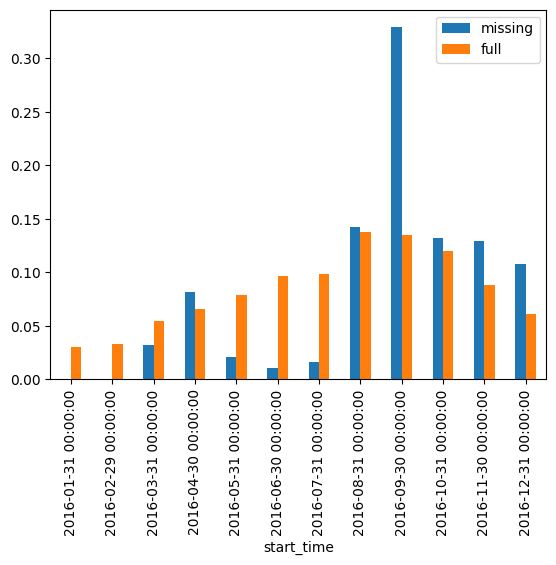

In [18]:
missing_users_viz = (missing_user_type.resample('M', on = 'start_time').count()['id']/len(missing_user_type)).rename('missing')
user_viz = (citi_bike.resample('M', on = 'start_time').count()['id']/len(citi_bike)).rename('full')
combo_user_viz = pd.concat([missing_users_viz, user_viz], axis = 1)
ax = combo_user_viz.plot.bar();

While the missing data is a small percentage of the total (less than one percent), looking at the distributions indicates that it might not be missing at random. From a data management standpoint, the null values can be kept in but renamed as an unknown category. This way that the analytics team can investigate further and we can keep an eye on the issue if we need to update the database at a later date.

In [19]:
citi_bike.fillna({'user_type': 'Unknown'}, inplace = True)

In [20]:
citi_bike.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247583 entries, 0 to 247583
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   trip_duration            247583 non-null  int64         
 1   start_time               247583 non-null  datetime64[ns]
 2   stop_time                247583 non-null  datetime64[ns]
 3   start_station_id         247583 non-null  int64         
 4   start_station_name       247583 non-null  object        
 5   start_station_latitude   247583 non-null  float64       
 6   start_station_longitude  247583 non-null  float64       
 7   end_station_id           247583 non-null  int64         
 8   end_station_name         247583 non-null  object        
 9   end_station_latitude     247583 non-null  float64       
 10  end_station_longitude    247583 non-null  float64       
 11  bike_id                  247583 non-null  int64         
 12  user_type            

#### `gender`

Let's confirm that most of the genders that are unknown are customers

In [21]:
citi_bike.groupby(['user_type', 'gender']).count()['id']

user_type   gender
Customer    0          15470
            1             36
            2             15
Subscriber  0           4431
            1         176898
            2          50353
Unknown     1            262
            2            118
Name: id, dtype: int64

Now that we have confirmed that most customers have an unknown gender, we won't delete those rows (to avoid removing a large amount of customers). We will need to be aware that demographic information that's useful is subscriber.

#### `trip_duration`

In this section we will investigate that suspiciously long trip duration.

In [22]:
citi_bike['trip_minutes'] = round(citi_bike['trip_duration'] / 60, 2)
citi_bike['trip_hours'] = round(citi_bike['trip_duration'] /(60**2), 2)
citi_bike[['trip_duration', 'trip_minutes', 'trip_hours']].describe()

,trip_duration,trip_minutes,trip_hours
count,2.475830e+05,247583.000000,247583.000000
mean,8.856300e+02,14.760494,0.246006
std,3.593805e+04,598.967493,9.982797
min,6.100000e+01,1.020000,0.020000
25%,2.480000e+02,4.130000,0.070000
50%,3.900000e+02,6.500000,0.110000
75%,6.660000e+02,11.100000,0.180000
max,1.632981e+07,272163.470000,4536.060000


The minimum trip length is 61 seconds and the maximum trip length was 4536 hours or 189 days

According to the data dictionary, trips under 60 seconds were already assumed to be false starts/stops and were removed. CitiBike policies state that the maximum trip length is 24 hours (or 86400 seconds).

We won't delete this record because it could correspond to a bike docking issue or users breaking the rules (which could be investigated by analysts). However, we will flag this for the analytic team that can filter them out if desired.

In [23]:
#creating a column to flag rides that don't comply with system protocols
citi_bike['valid_trip_duration'] = citi_bike['trip_duration'].apply(lambda x: 0 if x > 86400 else 1).astype(bool)

In [24]:
citi_bike.reset_index(drop = True, inplace = True)
citi_bike['id'] = citi_bike.index
citi_bike.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age,trip_minutes,trip_hours,valid_trip_duration
0,361,2016-02-01 00:31:18,2016-02-01 00:37:19,3202,Newport PATH,40.727224,-74.033759,3203,Hamilton Park,40.727596,-74.044247,24393,Subscriber,1975.0,1,0,41.0,6.02,0.10,True
1,297,2016-02-01 01:55:05,2016-02-01 02:00:02,3195,Sip Ave,40.730743,-74.063784,3194,McGinley Square,40.725340,-74.067622,24394,Subscriber,1985.0,2,1,31.0,4.95,0.08,True
2,1155,2016-02-01 02:40:05,2016-02-01 02:59:20,3183,Exchange Place,40.716247,-74.033459,3210,Pershing Field,40.742677,-74.051789,24676,Subscriber,1976.0,1,2,40.0,19.25,0.32,True
3,1769,2016-02-01 05:11:28,2016-02-01 05:40:58,3214,Essex Light Rail,40.712774,-74.036486,3203,Hamilton Park,40.727596,-74.044247,24700,Subscriber,1974.0,2,3,42.0,29.48,0.49,True
4,935,2016-02-01 05:48:24,2016-02-01 06:03:59,3203,Hamilton Park,40.727596,-74.044247,3214,Essex Light Rail,40.712774,-74.036486,24639,Subscriber,1974.0,2,4,42.0,15.58,0.26,True


Now that the Citi Bike data is clean, I will perform the same steps on the weather data.

### Weather Data

In this section we will follow some of the same steps that were performed above

In [25]:
newark_weather = pd.read_csv('data/newark_airport_2016.csv')
newark_weather.head()

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
0,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-01,12.75,NaN,0.0,0.0,0.0,41,43,34,NaN,270,280.0,25.9,35.1
1,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-02,9.40,NaN,0.0,0.0,0.0,36,42,30,NaN,260,260.0,21.0,25.1
2,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-03,10.29,NaN,0.0,0.0,0.0,37,47,28,NaN,270,250.0,23.9,30.0
3,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-04,17.22,NaN,0.0,0.0,0.0,32,35,14,NaN,330,330.0,25.9,33.1
4,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-05,9.84,NaN,0.0,0.0,0.0,19,31,10,NaN,360,350.0,25.1,31.1


In [26]:
#checking the dataframe's info
newark_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  366 non-null    object 
 1   NAME     366 non-null    object 
 2   DATE     366 non-null    object 
 3   AWND     366 non-null    float64
 4   PGTM     0 non-null      float64
 5   PRCP     366 non-null    float64
 6   SNOW     366 non-null    float64
 7   SNWD     366 non-null    float64
 8   TAVG     366 non-null    int64  
 9   TMAX     366 non-null    int64  
 10  TMIN     366 non-null    int64  
 11  TSUN     0 non-null      float64
 12  WDF2     366 non-null    int64  
 13  WDF5     364 non-null    float64
 14  WSF2     366 non-null    float64
 15  WSF5     364 non-null    float64
dtypes: float64(9), int64(4), object(3)
memory usage: 45.9+ KB


In [27]:
#five point stats
newark_weather.describe()

,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
count,366.000000,0.0,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,0.0,366.000000,364.000000,366.000000,364.000000
mean,9.429973,NaN,0.104945,0.098087,0.342623,57.196721,65.991803,48.459016,NaN,217.841530,228.269231,20.484426,26.801648
std,3.748174,NaN,0.307496,1.276498,2.078510,17.466981,18.606301,17.135790,NaN,102.548282,97.415777,6.848390,8.882610
min,2.460000,NaN,0.000000,0.000000,0.000000,8.000000,18.000000,0.000000,NaN,10.000000,10.000000,6.900000,10.100000
25%,6.765000,NaN,0.000000,0.000000,0.000000,43.000000,51.250000,35.000000,NaN,150.000000,150.000000,15.000000,19.900000
50%,8.720000,NaN,0.000000,0.000000,0.000000,56.000000,66.000000,47.000000,NaN,240.000000,260.000000,19.900000,25.100000
75%,11.410000,NaN,0.030000,0.000000,0.000000,74.000000,83.000000,64.000000,NaN,300.000000,300.000000,23.900000,31.100000
max,22.820000,NaN,2.790000,24.000000,20.100000,89.000000,99.000000,80.000000,NaN,360.000000,360.000000,48.100000,66.000000


In [28]:
#checking for missing values
newark_weather.isna().sum()

STATION      0
NAME         0
DATE         0
AWND         0
PGTM       366
PRCP         0
SNOW         0
SNWD         0
TAVG         0
TMAX         0
TMIN         0
TSUN       366
WDF2         0
WDF5         2
WSF2         0
WSF5         2
dtype: int64

In [29]:
#percentage of missing values
missing = 100 * (newark_weather.isnull().sum() / len(newark_weather))
print(missing)

STATION      0.000000
NAME         0.000000
DATE         0.000000
AWND         0.000000
PGTM       100.000000
PRCP         0.000000
SNOW         0.000000
SNWD         0.000000
TAVG         0.000000
TMAX         0.000000
TMIN         0.000000
TSUN       100.000000
WDF2         0.000000
WDF5         0.546448
WSF2         0.000000
WSF5         0.546448
dtype: float64


#### Cleaning and Transforming Weather data

For the weather data, there seems to be no information on PGTM (peak gust time) or TSUN (total daily sunlight) and will be dropped. The WDFx and WSFx refers to the fastest x-minute wind, and doesn't seem super relevant to our data since we don't know when the speed occurred. Therefore we only keep the AWND (average wind speed) as the wind variable. Because all the data we have is at one station, we'll those variables for now.

In [30]:
newark_weather.drop(['STATION', 'NAME', 'PGTM', 'TSUN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'], axis = 1, inplace = True)

In [31]:
newark_weather.dtypes

DATE     object
AWND    float64
PRCP    float64
SNOW    float64
SNWD    float64
TAVG      int64
TMAX      int64
TMIN      int64
dtype: object

In [32]:
#converting the date column to a datetime type
newark_weather['DATE'] = pd.to_datetime(newark_weather['DATE'], yearfirst = True)

In [33]:
newark_weather.dtypes

DATE    datetime64[ns]
AWND           float64
PRCP           float64
SNOW           float64
SNWD           float64
TAVG             int64
TMAX             int64
TMIN             int64
dtype: object

In [34]:
newark_weather.describe()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
count,366,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2016-07-01 12:00:00,9.429973,0.104945,0.098087,0.342623,57.196721,65.991803,48.459016
min,2016-01-01 00:00:00,2.460000,0.000000,0.000000,0.000000,8.000000,18.000000,0.000000
25%,2016-04-01 06:00:00,6.765000,0.000000,0.000000,0.000000,43.000000,51.250000,35.000000
50%,2016-07-01 12:00:00,8.720000,0.000000,0.000000,0.000000,56.000000,66.000000,47.000000
75%,2016-09-30 18:00:00,11.410000,0.030000,0.000000,0.000000,74.000000,83.000000,64.000000
max,2016-12-31 00:00:00,22.820000,2.790000,24.000000,20.100000,89.000000,99.000000,80.000000
std,NaN,3.748174,0.307496,1.276498,2.078510,17.466981,18.606301,17.135790


Checking the five point statistics that are no obvious outliers 

Let's check for nulls:

In [35]:
newark_weather.isna().sum()

DATE    0
AWND    0
PRCP    0
SNOW    0
SNWD    0
TAVG    0
TMAX    0
TMIN    0
dtype: int64

Next we'll rename the column names to make them clearer

In [36]:
newark_weather.columns = ['rec_date', 'avg_wind', 'prcp', 'snow_amt', 'snow_depth', 'tavg', 'tmax', 'tmin']

In [37]:
#create binary columns for weather events
newark_weather['rain'] = newark_weather['prcp'].apply(lambda x: 1 if x > 0 else 0).astype(bool)
newark_weather['snow'] = newark_weather['snow_amt'].apply(lambda x: 1 if x > 0 else 0).astype(bool)

In [38]:
newark_weather.head()

,rec_date,avg_wind,prcp,snow_amt,snow_depth,tavg,tmax,tmin,rain,snow
0,2016-01-01,12.75,0.0,0.0,0.0,41,43,34,False,False
1,2016-01-02,9.40,0.0,0.0,0.0,36,42,30,False,False
2,2016-01-03,10.29,0.0,0.0,0.0,37,47,28,False,False
3,2016-01-04,17.22,0.0,0.0,0.0,32,35,14,False,False
4,2016-01-05,9.84,0.0,0.0,0.0,19,31,10,False,False


### Postgres Tables
Now in this section, we'll formatting the data into different tables to be stored on the database. Since our data is date dependent, it makes sense to create a data dimension table to simplify future queries. This table will have information about the full date, the month, day, day of the week and weekend information

In [39]:
start = datetime.datetime(2016, 1, 1)
#generate the remaining days of the yeae
date_col = [start + datetime.timedelta(x) for x in range(366)]

#create date dataframe
date_df = pd.DataFrame(date_col, dtype='datetime64[ns]')
date_df.columns = ['full_date']
date_df.head()

,full_date
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05


In [40]:
#generating the month and day names
date_df['month'] = date_df['full_date'].apply(lambda x: x.month)
date_df['day'] = date_df['full_date'].apply(lambda x: x.day)
date_df['month_name'] = date_df['full_date'].apply(lambda x: x.strftime('%B'))
date_df['day_name'] = date_df['full_date'].apply(lambda x: x.strftime('%A'))
date_df['weekend'] = date_df['day_name'].apply(lambda x: 1 if (x == 'Saturday') | (x == 'Sunday') else 0).astype(bool)

date_df.head()

,full_date,month,day,month_name,day_name,weekend
0,2016-01-01,1,1,January,Friday,False
1,2016-01-02,1,2,January,Saturday,True
2,2016-01-03,1,3,January,Sunday,True
3,2016-01-04,1,4,January,Monday,False
4,2016-01-05,1,5,January,Tuesday,False


Now that we have all the relevant date info, we'll need to add a date key column which will act as the table's primary key and a foreign key in the other tables.

In [41]:
date_df['date_key'] = date_df['full_date'].apply(lambda x: int(x.strftime('%Y%m%d')))
newark_weather['date_key'] = newark_weather['rec_date'].apply(lambda x: int(x.strftime('%Y%m%d')))
citi_bike['date_key'] = citi_bike['start_time'].apply(lambda x: int(x.strftime('%Y%m%d')))
date_df.head()

,full_date,month,day,month_name,day_name,weekend,date_key
0,2016-01-01,1,1,January,Friday,False,20160101
1,2016-01-02,1,2,January,Saturday,True,20160102
2,2016-01-03,1,3,January,Sunday,True,20160103
3,2016-01-04,1,4,January,Monday,False,20160104
4,2016-01-05,1,5,January,Tuesday,False,20160105


### User Table
In this section, we'll create a user table storing demographic information

In [42]:
users = citi_bike[['user_type', 'birth_year', 'gender', 'age']].drop_duplicates(subset = ['user_type', 'birth_year', 'gender']).reset_index(drop = True)
users['user_id'] = users.index

#creating the ride table
rides = citi_bike.merge(users, on=['user_type', 'birth_year', 'gender', 'age']).sort_values(by='id').reset_index(drop=True)

# drop the demographic info from rides
rides = rides.drop(['user_type','birth_year','gender','age'],axis=1)

rides.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,id,trip_minutes,trip_hours,valid_trip_duration,date_key,user_id
0,361,2016-02-01 00:31:18,2016-02-01 00:37:19,3202,Newport PATH,40.727224,-74.033759,3203,Hamilton Park,40.727596,-74.044247,24393,0,6.02,0.10,True,20160201,0
1,297,2016-02-01 01:55:05,2016-02-01 02:00:02,3195,Sip Ave,40.730743,-74.063784,3194,McGinley Square,40.725340,-74.067622,24394,1,4.95,0.08,True,20160201,1
2,1155,2016-02-01 02:40:05,2016-02-01 02:59:20,3183,Exchange Place,40.716247,-74.033459,3210,Pershing Field,40.742677,-74.051789,24676,2,19.25,0.32,True,20160201,2
3,1769,2016-02-01 05:11:28,2016-02-01 05:40:58,3214,Essex Light Rail,40.712774,-74.036486,3203,Hamilton Park,40.727596,-74.044247,24700,3,29.48,0.49,True,20160201,3
4,935,2016-02-01 05:48:24,2016-02-01 06:03:59,3203,Hamilton Park,40.727596,-74.044247,3214,Essex Light Rail,40.712774,-74.036486,24639,4,15.58,0.26,True,20160201,3


In [43]:
ridesmerge = rides.merge(users, on='user_id').sort_values(by='id').reset_index(drop=True)

(citi_bike.ne(ridesmerge) & (citi_bike.notna() | ridesmerge.notna())).sum()

age                        0
bike_id                    0
birth_year                 0
date_key                   0
end_station_id             0
end_station_latitude       0
end_station_longitude      0
end_station_name           0
gender                     0
id                         0
start_station_id           0
start_station_latitude     0
start_station_longitude    0
start_station_name         0
start_time                 0
stop_time                  0
trip_duration              0
trip_hours                 0
trip_minutes               0
user_id                    0
user_type                  0
valid_trip_duration        0
dtype: int64

In [44]:
users.head()

,user_type,birth_year,gender,age,user_id
0,Subscriber,1975.0,1,41.0,0
1,Subscriber,1985.0,2,31.0,1
2,Subscriber,1976.0,1,40.0,2
3,Subscriber,1974.0,2,42.0,3
4,Subscriber,1984.0,2,32.0,4


### Stations Table
In order to make this table more readable, I will just input information about station id, station id and station latitude and longitude

In [45]:
starts =  rides[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']]
ends = rides[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']]

starts.columns = ['station_id', 'station_name', 'station_latitude', 'station_longitude']
ends.columns = ['station_id', 'station_name', 'station_latitude', 'station_longitude']

stations = pd.concat([starts, ends]).drop_duplicates()

#dropping station info from rides tables
rides = rides.drop(['start_station_name', 'start_station_latitude', 'start_station_longitude', 'end_station_name', 'end_station_latitude', 'end_station_longitude'], axis = 1)
rides.rename({'id': 'user_id'}, inplace = True)
rides['id'] = rides.index
rides.head()

,trip_duration,start_time,stop_time,start_station_id,end_station_id,bike_id,id,trip_minutes,trip_hours,valid_trip_duration,date_key,user_id
0,361,2016-02-01 00:31:18,2016-02-01 00:37:19,3202,3203,24393,0,6.02,0.10,True,20160201,0
1,297,2016-02-01 01:55:05,2016-02-01 02:00:02,3195,3194,24394,1,4.95,0.08,True,20160201,1
2,1155,2016-02-01 02:40:05,2016-02-01 02:59:20,3183,3210,24676,2,19.25,0.32,True,20160201,2
3,1769,2016-02-01 05:11:28,2016-02-01 05:40:58,3214,3203,24700,3,29.48,0.49,True,20160201,3
4,935,2016-02-01 05:48:24,2016-02-01 06:03:59,3203,3214,24639,4,15.58,0.26,True,20160201,3


In [46]:
stations.head()

,station_id,station_name,station_latitude,station_longitude
0,3202,Newport PATH,40.727224,-74.033759
1,3195,Sip Ave,40.730743,-74.063784
2,3183,Exchange Place,40.716247,-74.033459
3,3214,Essex Light Rail,40.712774,-74.036486
4,3203,Hamilton Park,40.727596,-74.044247


### Weather Table
Because the weather table only has relevant weather information, no changes will be made

In [58]:
newark_weather['id'] = newark_weather.index
newark_weather.head()

,rec_date,avg_wind,prcp,snow_amt,snow_depth,tavg,tmax,tmin,rain,snow,date_key,id,weather_id
0,2016-01-01,12.75,0.0,0.0,0.0,41,43,34,False,False,20160101,0,0
1,2016-01-02,9.40,0.0,0.0,0.0,36,42,30,False,False,20160102,1,1
2,2016-01-03,10.29,0.0,0.0,0.0,37,47,28,False,False,20160103,2,2
3,2016-01-04,17.22,0.0,0.0,0.0,32,35,14,False,False,20160104,3,3
4,2016-01-05,9.84,0.0,0.0,0.0,19,31,10,False,False,20160105,4,4


### Database Code

In [49]:
engine = sqlalchemy.create_engine('postgresql://localhost/bike_rental')
con = engine.connect()

In [59]:
date_df.to_sql('date_dim', con, if_exists = 'append', index = False, chunksize=10000)
stations.to_sql('stations', con, if_exists = 'append', index = False, chunksize=10000)
users.to_sql('users', con, if_exists = 'append', index = False, chunksize=10000)
rides.to_sql('rides', con, if_exists = 'append', index = False, chunksize=10000)
newark_weather.to_sql('weather', con, if_exists = 'append', index = False, chunksize=10000)
con.close()

IntegrityError: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "rides_pkey"
DETAIL:  Key (id)=(0) already exists.

[SQL: INSERT INTO rides (trip_duration, start_time, stop_time, start_station_id, end_station_id, bike_id, id, trip_minutes, trip_hours, valid_trip_duration, date_key, user_id) VALUES (%(trip_duration__0)s, %(start_time__0)s, %(stop_time__0)s, %(start_stati ... 259505 characters truncated ... utes__999)s, %(trip_hours__999)s, %(valid_trip_duration__999)s, %(date_key__999)s, %(user_id__999)s)]
[parameters: {'id__0': 0, 'trip_minutes__0': 6.02, 'end_station_id__0': 3203, 'start_time__0': datetime.datetime(2016, 2, 1, 0, 31, 18), 'user_id__0': 0, 'valid_trip_duration__0': True, 'trip_duration__0': 361, 'bike_id__0': 24393, 'start_station_id__0': 3202, 'trip_hours__0': 0.1, 'date_key__0': 20160201, 'stop_time__0': datetime.datetime(2016, 2, 1, 0, 37, 19), 'id__1': 1, 'trip_minutes__1': 4.95, 'end_station_id__1': 3194, 'start_time__1': datetime.datetime(2016, 2, 1, 1, 55, 5), 'user_id__1': 1, 'valid_trip_duration__1': True, 'trip_duration__1': 297, 'bike_id__1': 24394, 'start_station_id__1': 3195, 'trip_hours__1': 0.08, 'date_key__1': 20160201, 'stop_time__1': datetime.datetime(2016, 2, 1, 2, 0, 2), 'id__2': 2, 'trip_minutes__2': 19.25, 'end_station_id__2': 3210, 'start_time__2': datetime.datetime(2016, 2, 1, 2, 40, 5), 'user_id__2': 2, 'valid_trip_duration__2': True, 'trip_duration__2': 1155, 'bike_id__2': 24676, 'start_station_id__2': 3183, 'trip_hours__2': 0.32, 'date_key__2': 20160201, 'stop_time__2': datetime.datetime(2016, 2, 1, 2, 59, 20), 'id__3': 3, 'trip_minutes__3': 29.48, 'end_station_id__3': 3203, 'start_time__3': datetime.datetime(2016, 2, 1, 5, 11, 28), 'user_id__3': 3, 'valid_trip_duration__3': True, 'trip_duration__3': 1769, 'bike_id__3': 24700, 'start_station_id__3': 3214, 'trip_hours__3': 0.49, 'date_key__3': 20160201, 'stop_time__3': datetime.datetime(2016, 2, 1, 5, 40, 58), 'id__4': 4, 'trip_minutes__4': 15.58 ... 11900 parameters truncated ... 'date_key__995': 20160203, 'stop_time__995': datetime.datetime(2016, 2, 3, 20, 34, 5), 'id__996': 996, 'trip_minutes__996': 7.48, 'end_station_id__996': 3183, 'start_time__996': datetime.datetime(2016, 2, 3, 20, 27, 13), 'user_id__996': 77, 'valid_trip_duration__996': True, 'trip_duration__996': 449, 'bike_id__996': 24501, 'start_station_id__996': 3211, 'trip_hours__996': 0.12, 'date_key__996': 20160203, 'stop_time__996': datetime.datetime(2016, 2, 3, 20, 34, 42), 'id__997': 997, 'trip_minutes__997': 8.48, 'end_station_id__997': 3212, 'start_time__997': datetime.datetime(2016, 2, 3, 20, 27, 34), 'user_id__997': 31, 'valid_trip_duration__997': True, 'trip_duration__997': 509, 'bike_id__997': 24425, 'start_station_id__997': 3195, 'trip_hours__997': 0.14, 'date_key__997': 20160203, 'stop_time__997': datetime.datetime(2016, 2, 3, 20, 36, 3), 'id__998': 998, 'trip_minutes__998': 6.15, 'end_station_id__998': 3193, 'start_time__998': datetime.datetime(2016, 2, 3, 20, 31, 37), 'user_id__998': 37, 'valid_trip_duration__998': True, 'trip_duration__998': 369, 'bike_id__998': 24511, 'start_station_id__998': 3195, 'trip_hours__998': 0.1, 'date_key__998': 20160203, 'stop_time__998': datetime.datetime(2016, 2, 3, 20, 37, 46), 'id__999': 999, 'trip_minutes__999': 6.07, 'end_station_id__999': 3213, 'start_time__999': datetime.datetime(2016, 2, 3, 20, 36, 33), 'user_id__999': 16, 'valid_trip_duration__999': True, 'trip_duration__999': 364, 'bike_id__999': 24588, 'start_station_id__999': 3194, 'trip_hours__999': 0.1, 'date_key__999': 20160203, 'stop_time__999': datetime.datetime(2016, 2, 3, 20, 42, 37)}]
(Background on this error at: https://sqlalche.me/e/20/gkpj)